<a href="https://colab.research.google.com/github/nabeel-gulzar/multinomial-logistic-regression/blob/main/Multinomial_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# %pip install gdown
# !gdown --id '1GbfEJ4JnTGthMs4RP5z17BrCQm6YxtEG'
# !unzip LUMS_FALL2020_PROJECT_DATA.zip
# !pip install python_speech_features

In [4]:
import glob
import numpy as np
import python_speech_features as mfcc
from scipy.io.wavfile import read
from pathlib import Path
from time import time
from sklearn import metrics
from matplotlib import pyplot as plt
from math import floor
import pandas as pd

In [5]:
gender_data_dir = 'Gender_Recognition/'
speaker_data_dir = 'Speaker_Recognition/'
valid_dir = 'Valid/'
test_dir = 'Test/'
train_dir = 'Train/'

In [6]:
def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)

In [7]:
class Time(object):
    def __init__(self, description):
      self.description = description

    def __enter__(self): 
        self.start_time = time()
  
    def __exit__(self, et, ev, tb):
        print("Time for {}: {:.4f}".format(self.description, time()-self.start_time))

Data Loading Functions

In [8]:
def load_data(directory):
  genders = []
  speakers = []
  feature_matrix = []
  for filename in glob.iglob(directory+'*/*.wav', recursive=True):
    sr, audio = read(filename)
    feature_vector = get_MFCC(audio, sr)
    feature_matrix.append(feature_vector)
    id = filename.split('/')[-2].split('_')
    speakers.append(id[0])
    genders.append(id[1])
  return np.array(feature_matrix), np.array(genders), np.array(speakers)

Data Preprocessing Functions

In [9]:
def one_hot(label_vector, unique_categories):
  # convert the given label vector into a one hot encoding matrix
  label_vector_indexed = [np.where(unique_categories == label)[0][0] for label in label_vector]
  classes_count = unique_categories.shape[0]
  return np.eye(classes_count, dtype=np.int8)[label_vector_indexed]

def normalize(train, validation, test):
  train_mean = train.mean(axis=0)
  train_std = train.std(axis=0)
  train = (train - train_mean)/train_std
  validation = (validation - train_mean)/train_std
  test = (test - train_mean)/train_std
  return train, validation, test

# adding feature with value 1 to ease computation
def add_ones_feature(train, validation, test):
  train = np.append(np.ones((train.shape[0], 1)), train, axis=1)
  validation = np.append(np.ones((validation.shape[0], 1)), validation, axis=1)
  test = np.append(np.ones((test.shape[0], 1)), test, axis=1)
  return train, validation, test

Plotting Functions

In [10]:
def plot_cost(J, xlabel='Iteration', ylabel='Cost', title='Cost w.r.t iteration'):
    fig, ax = plt.subplots(1, 2)
    # resize the figure
    fig.set_size_inches(8, 3)
    # set title
    fig.suptitle(title)
    for chart_idx in range(2):
      xvalues = [idx for idx in range(len(J[chart_idx]))]
      ax[chart_idx].plot(xvalues, J[chart_idx], '-')

Logistic Regression Core Functions

In [11]:
def softmax(probabilities):
  # given a set of raw probabilities convert them into legel probabilities summing upto 1
  exp_probabilities = np.exp(probabilities)
  return exp_probabilities/np.sum(exp_probabilities, axis=1, keepdims=True)

def predict(features, thetas, apply_softmax=True):
  # return label_vector with sigmoid values
  raw_scores = np.matmul(features, thetas.T)
  if apply_softmax:
    return softmax(raw_scores)
  return raw_scores

def compute_cost(actual_labels, softmax_probabilities):
  # return cross entropy loss
  return -1 * (actual_labels * np.log(softmax_probabilities)).sum() /actual_labels.shape[0]

def assign_actual_labels(softmax_probabilities):
  return np.argmax(softmax_probabilities, axis=1)

In [12]:
# def gradient_descent(train_features, train_labels, **kw_args):
#   # return theta_matrix with shape(C,X) where C in the number pf classes and X in the feature vector size
#   alpha = kw_args.get('alpha', 0.05)
#   epochs = kw_args.get('epochs', 1000)
#   features_count = train_features.shape[1]
#   classes_count = train_labels.shape[1]
#   training_count = train_features.shape[0]
#   thetas = np.zeros((classes_count, features_count))
#   for i in range(epochs):
#     softmax_probabilities = predict(train_features, thetas)
#     delta =softmax_probabilities -  train_labels
#     gradient = np.matmul(delta.T, train_features)
#     thetas -= alpha*(gradient/training_count)
#   return thetas

def optimized_gradient_descent(train_features, train_labels, **kw_args):
  # return theta_matrix with shape(C,X) where C in the number pf classes and X in the feature vector size
  alpha_list = kw_args.get('alpha_list', [0.5, 0.05, 0.025, 0.01])
  epochs_list = kw_args.get('epochs_list', [500, 1000, 1500])
  validation_features = kw_args['validation_features']
  validation_labels = kw_args['validation_labels']
  features_count = train_features.shape[1]
  classes_count = train_labels.shape[1]
  training_count = train_features.shape[0]
  thetas = np.zeros((classes_count, features_count))
  optmized_thetas = None
  optimized_alpha = None
  optimized_epochs = None
  min_validation_cost = 99999
  for alpha in alpha_list:
    for epochs in epochs_list:
      train_iteration_costs = list()
      validation_iteration_costs = list()
      for i in range(epochs):
        softmax_probabilities = predict(train_features, thetas)
        train_cost = compute_cost(train_labels, softmax_probabilities)
        validation_cost = compute_cost(validation_labels, predict(validation_features, thetas))
        train_iteration_costs.append(train_cost)
        validation_iteration_costs.append(validation_cost)
        delta = softmax_probabilities - train_labels
        gradient = np.matmul(delta.T, train_features)
        thetas -= alpha*(gradient/training_count)
      validation_cost = validation_iteration_costs[-1]
      if kw_args.get('show_plot', True):
        title = "Alpha: {:.4f}, Epochs: {}, Validation Cost: {:.4f}".format(alpha, epochs, validation_cost)
        plot_cost([train_iteration_costs, validation_iteration_costs], title=title)
      if validation_cost < min_validation_cost:
        min_validation_cost = validation_cost
        optmized_thetas = thetas
        optimized_alpha = alpha
        optimized_epochs = epochs
  return optmized_thetas, optimized_alpha, optimized_epochs

# Gender Recognition

Data Loading

In [13]:
with Time("Loading Gender Classification Data"):
  train_features, train_genders, _ = load_data(gender_data_dir+train_dir)
  validation_features, validation_genders, _ = load_data(gender_data_dir+valid_dir)
  test_features, test_genders, _ = load_data(gender_data_dir+test_dir)

Time for Loading Gender Classification Data: 55.3282


Data Preprocessing

In [185]:
unique_genders = np.unique(train_genders)
with Time("Converting label vectors to one-hot"):
  train_genders_hot = one_hot(train_genders, unique_genders)
  validation_genders_hot = one_hot(validation_genders, unique_genders)
  test_genders_hot = one_hot(test_genders, unique_genders)

Time for Converting label vectors to one-hot: 0.0253


In [186]:
with Time("Normalizing Data"):
  train_features, validation_features, test_features = normalize(train_features, validation_features, test_features)

Time for Normalizing Data: 0.0034


In [187]:
# adding feature with value 1 to ease computation
with Time("Adding feature with vlaue 1"):
  train_features, validation_features, test_features = add_ones_feature(train_features, validation_features, test_features)

Time for Adding feature with vlaue 1: 0.0040


Model Training

Time for Running Gradient Descent: 14.8052


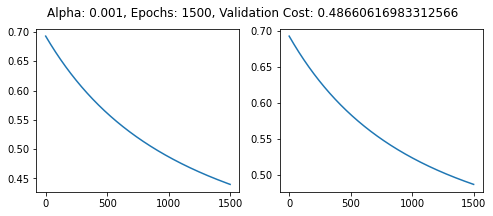

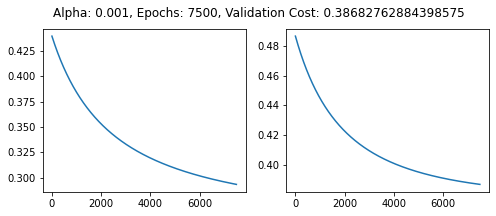

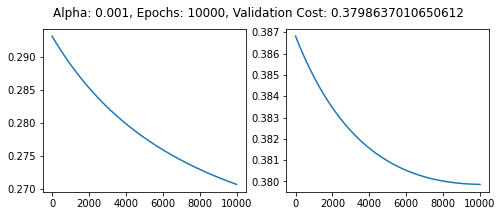

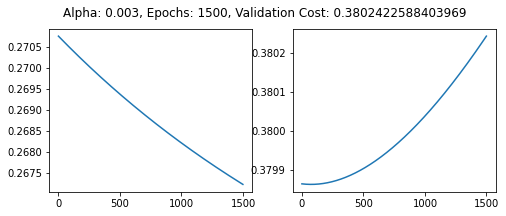

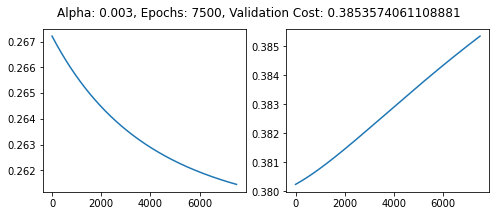

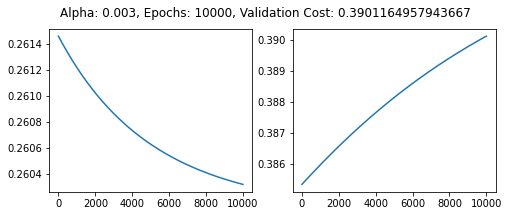

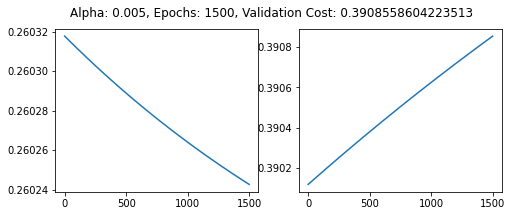

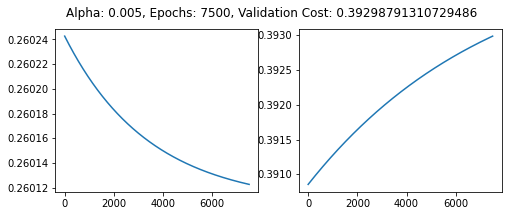

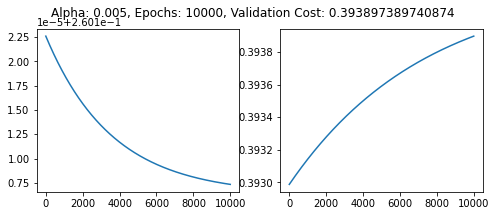

In [210]:
with Time("Running Gradient Descent"):
  thetas, alpha, epochs = optimized_gradient_descent(train_features=train_features,
                                      train_labels=train_genders_hot,
                                      validation_features=validation_features,
                                      validation_labels=validation_genders_hot,
                                      alpha_list=np.arange(0.001, 0.006, 0.002),
                                      epochs_list=[1500, 7500, 10000],
                                      show_plot=True)

Hyperparams Found By Minimizing Validation Loss

In [211]:
print("Alpha: {:.4f}, Epochs: {}".format(alpha, epochs))

Alpha: 0.0010, Epochs: 10000


In [212]:
softmax_probabilities = predict(test_features, thetas)
predicted_genders = assign_actual_labels(softmax_probabilities)
actual_genders = np.vectorize(lambda x: np.where(unique_genders==x)[0][0])(test_genders)
accuracy_score = metrics.accuracy_score(actual_genders, predicted_genders)
unique_genders_idx = np.arange(0, unique_genders.shape[0], 1)
confusion_matrix = metrics.confusion_matrix(actual_genders, predicted_genders, unique_genders_idx)

Accuracy of Gender Classifier on Test Data

In [213]:
print("Accuracy: {:.2f}% with Alpha: {:.4f}, Epochs: {}".format(accuracy_score*100, alpha, epochs))

Accuracy: 85.29% with Alpha: 0.0010, Epochs: 10000


Confusion Matrix of Gender Classifier on Test Data

In [214]:
pd.DataFrame(data=confusion_matrix, columns=unique_genders, index=unique_genders)

,F,M
F,25,15
M,10,120


Macro Average F1 Score of Gender Classifier on Test Data

In [215]:
classification_report_speaker = metrics.classification_report(actual_genders, predicted_genders, target_names=unique_genders, output_dict=True)
print("Macro Average F1: {:.4f}".format(classification_report_speaker['macro avg']['f1-score']))

Macro Average F1: 0.7862


## Speaker Recognition

Data Loading

In [216]:
with Time("Loading Speaker Classification Data"):
  train_features, _, train_speakers = load_data(speaker_data_dir+train_dir)
  validation_features, _, validation_speakers = load_data(speaker_data_dir+valid_dir)
  test_features, _, test_speakers = load_data(speaker_data_dir+test_dir)

Time for Loading Speaker Classification Data: 53.2211


Data Preprocessing

In [217]:
unique_speakers = np.unique(train_speakers)
with Time("Converting label vectors to one-hot"):
  train_speakers_hot = one_hot(train_speakers, unique_speakers)
  validation_speakers_hot = one_hot(validation_speakers, unique_speakers)
  test_speakers_hot = one_hot(test_speakers, unique_speakers)

Time for Converting label vectors to one-hot: 0.0098


In [218]:
with Time("Normalizing Data"):
  train_features, validation_features, test_features = normalize(train_features, validation_features, test_features)

Time for Normalizing Data: 0.0008


In [219]:
# adding feature with value 1 to ease computation
with Time("Adding feature with vlaue 1"):
  train_features, validation_features, test_features = add_ones_feature(train_features, validation_features, test_features)

Time for Adding feature with vlaue 1: 0.0003


Model Training

Time for Running Gradient Descent For Speaker Classification: 352.2334


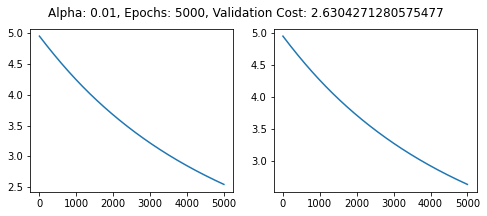

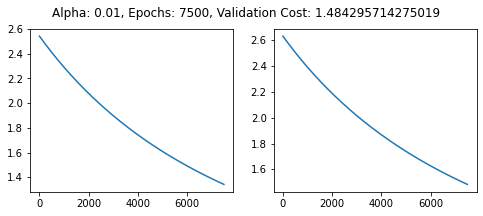

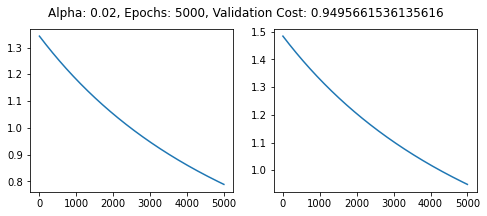

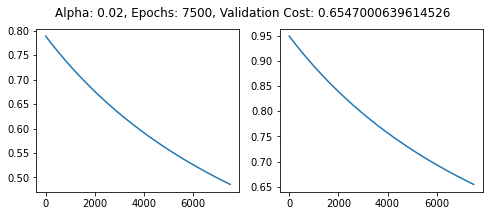

In [220]:
with Time("Running Gradient Descent For Speaker Classification"):
  thetas, alpha, epochs = optimized_gradient_descent(train_features=train_features,
                                      train_labels=train_speakers_hot,
                                      validation_features=validation_features,
                                      validation_labels=validation_speakers_hot,
                                      alpha_list=np.arange(0.01, 0.03, 0.01),
                                      epochs_list=[5000, 7500],
                                      show_plot=True)

Hyperparams Found By Minimizing Validation Loss

In [221]:
print("Alpha: {:.4f}, Epochs: {:d}".format(alpha, epochs))

Alpha: 0.0200, Epochs: 7500


In [223]:
softmax_probabilities = predict(test_features, thetas)
predicted_speakers = assign_actual_labels(softmax_probabilities)
actual_speakers = np.vectorize(lambda x: np.where(unique_speakers==x)[0][0])(test_speakers)
accuracy_score = metrics.accuracy_score(actual_speakers, predicted_speakers)
unique_speakers_idx = np.arange(0, unique_speakers.shape[0], 1)
confusion_matrix = metrics.confusion_matrix(actual_speakers, predicted_speakers, unique_speakers_idx)

Accuracy of Speaker Classifier on Test Data

In [225]:
print("Accuracy: {:.2f} with Alpha: {:.4f}, Epochs: {}".format(accuracy_score*100, alpha, epochs))

Accuracy: 96.83 with Alpha: 0.0200, Epochs: 7500


Confusion Matrix of Speaker Classifier on Test Data

In [226]:
pd.DataFrame(data=confusion_matrix, columns=unique_speakers, index=unique_speakers)

,SPK001,SPK002,SPK003,SPK004,SPK005,SPK006,SPK007,SPK008,SPK009,SPK010,SPK011,SPK012,SPK013,SPK014,SPK015,SPK016,SPK017,SPK018,SPK019,SPK020,SPK021,SPK022,SPK023,SPK024,SPK025,SPK026,SPK027,SPK028,SPK029,SPK030,SPK031,SPK032,SPK033,SPK034,SPK035,SPK036,SPK037,SPK038,SPK039,SPK040,...,SPK103,SPK104,SPK105,SPK106,SPK107,SPK108,SPK109,SPK110,SPK111,SPK112,SPK113,SPK114,SPK115,SPK116,SPK117,SPK118,SPK119,SPK120,SPK121,SPK122,SPK123,SPK124,SPK125,SPK126,SPK127,SPK128,SPK129,SPK130,SPK131,SPK132,SPK133,SPK134,SPK135,SPK136,SPK137,SPK138,SPK139,SPK140,SPK141,SPK142
SPK001,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SPK002,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SPK003,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SPK004,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SPK005,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPK138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
SPK139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0
SPK140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
SPK141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0


Macro Average F1 Score of Speaker Classifier on Test Data

In [227]:
classification_report_speaker = metrics.classification_report(actual_speakers, predicted_speakers, target_names=unique_speakers, output_dict=True)
print("Macro Average F1: {:.4f}".format(classification_report_speaker['macro avg']['f1-score']))

Macro Average F1: 0.9664


In [17]:
tf, tg, ts = load_data(gender_data_dir+train_dir)

In [18]:
tg[:30]

array(['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M'], dtype='<U1')

In [19]:
ts[:30]

array(['SPK116', 'SPK116', 'SPK116', 'SPK116', 'SPK116', 'SPK116',
       'SPK116', 'SPK116', 'SPK116', 'SPK116', 'SPK065', 'SPK065',
       'SPK065', 'SPK065', 'SPK065', 'SPK065', 'SPK065', 'SPK065',
       'SPK065', 'SPK065', 'SPK073', 'SPK073', 'SPK073', 'SPK073',
       'SPK073', 'SPK073', 'SPK073', 'SPK073', 'SPK073', 'SPK073'],
      dtype='<U6')